## generate prediction

In [51]:
import pandas as pd
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
import joblib
import numpy as np

tgt = 'soc_log1p'
version = 'v20250301'

covs = pd.read_csv(f'./metric/feature_selected_soc_{version}.txt', header=None)[0].tolist() 
model = joblib.load(f'./model/model_rf.soc_ccc_{version}.joblib')
model.n_jobs = 90

train = pd.read_parquet(f'./material/data_train_soc_{version}.pq')
train[tgt] = np.log1p(train['soc'])
train = train.dropna(subset=covs+[tgt],how='any')
test = pd.read_parquet(f'./material/data_test.all_soc_{version}.pq')
test[tgt] = np.log1p(test['soc'])
test = test.dropna(subset=covs+[tgt],how='any')

# train = train.loc[train['soc']<50]
# test = test.loc[test['soc']<50]

ttprint(f'start test prediction')
model.fit(train[covs], train[tgt])
y_val = model.predict(test[covs])
ttprint(f'finish test prediction')
test[f'{tgt}_test'] = y_val

# variable importance
importance_df = pd.DataFrame({'feature': covs, 'importance': model.feature_importances_})
importance_df = importance_df.sort_values(by='importance', ascending=False)
# importance_df.to_csv(f'./material/feature_importance_{version}.csv', index=False)


[15:23:53] start test prediction


/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


[15:23:55] finish test prediction


## evaluate prediction accuracy

/tmp/ipykernel_398560/723112226.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar


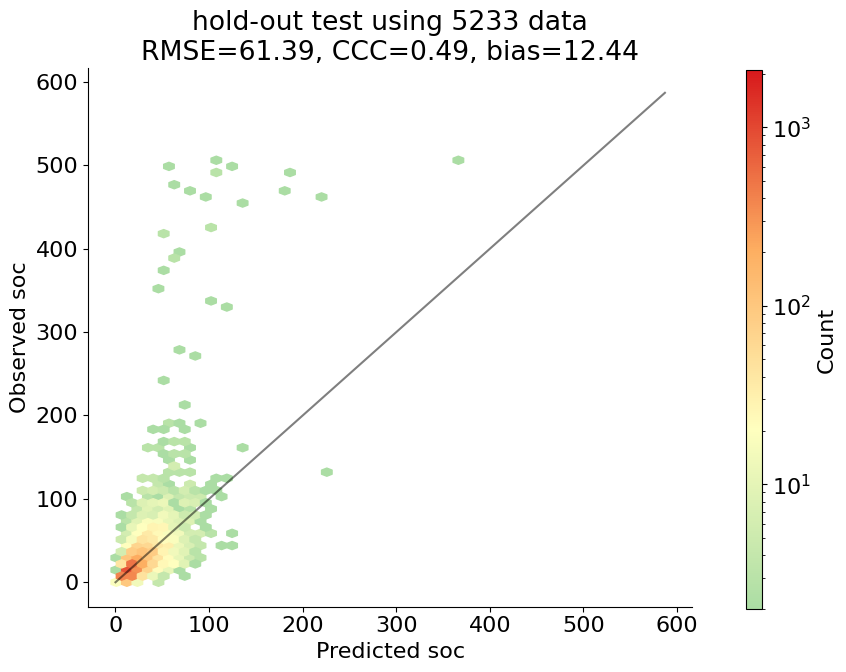

In [52]:
from matplotlib.colors import LinearSegmentedColormap
from model_fit import calc_metrics
import math
import numpy as np
import matplotlib.pyplot as plt

cet_l19_cmap = LinearSegmentedColormap.from_list(
    "CET-L19", ["#abdda4", "#ffffbf", "#fdae61", "#d7191c"]
)

y_pred = np.expm1(test[f'{tgt}_test'])
y_test = test['soc']
rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_pred, y_test, 'normal')

# y_pred = test[f'{tgt}_test']
# y_test = test['soc_log1p']
# rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_pred, y_test, 'log1p')
    
show_range = [
    math.floor(np.min([y_test.min(), y_pred.min()])),
    math.ceil(np.max([y_test.max(), y_pred.max()]))]
# show_range = [0,100]
vmax = 0.4 * len(y_test)

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(8, 7))

ax.set_title(f'hold-out test using {len(y_test)} data\nRMSE={rmse:.2f}, CCC={ccc:.2f}, bias={bias:.2f}')

# Use the CET-L19 colorblind-friendly colormap
hb = ax.hexbin(y_pred, y_test, gridsize=(40, 40), cmap=cet_l19_cmap,mincnt=2, vmax=vmax, bins='log')
ax.set_xlabel(f'Predicted soc')
ax.set_ylabel(f'Observed soc')
ax.set_aspect('auto', adjustable='box')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(show_range, show_range, "-k", alpha=.5)

# Create a colorbar with proper spacing
cax = fig.add_axes([ax.get_position().x1 + 0.05, ax.get_position().y0, 0.02, ax.get_position().height])
cb = fig.colorbar(hb, cax=cax)
cb.set_label('Count')

plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar
# plt.savefig(f'{output_folder}/plot_accuracy.{test_type}_{mdl}.{prop}.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_398560/1049411615.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar


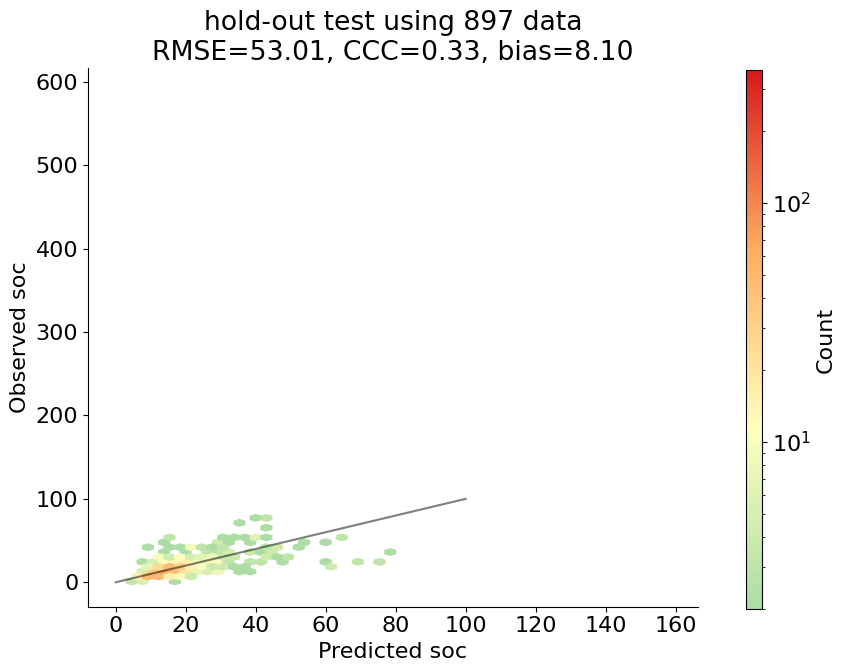

In [54]:
ttid = pd.read_csv('./material/test_temporal_ids.txt', header=None)[0].tolist() 
ttid = [str(ii) for ii in ttid]
ttest = test.loc[test['id'].isin(ttid)]

y_pred = np.expm1(ttest[f'{tgt}_test'])
y_test = ttest['soc']
rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_pred, y_test, 'normal')

# y_pred = ttest[f'{tgt}_test']
# y_test = ttest['soc_log1p']
# rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_pred, y_test, 'log1p')
    
# show_range = [
#     math.floor(np.min([y_test.min(), y_pred.min()])),
#     math.ceil(np.max([y_test.max(), y_pred.max()]))]
show_range = [0,100]
vmax = 0.4 * len(y_test)

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(8, 7))

ax.set_title(f'hold-out test using {len(y_test)} data\nRMSE={rmse:.2f}, CCC={ccc:.2f}, bias={bias:.2f}')

# Use the CET-L19 colorblind-friendly colormap
hb = ax.hexbin(y_pred, y_test, gridsize=(50, 50), cmap=cet_l19_cmap,mincnt=2, vmax=vmax, bins='log')
ax.set_xlabel(f'Predicted soc')
ax.set_ylabel(f'Observed soc')
ax.set_aspect('auto', adjustable='box')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(show_range, show_range, "-k", alpha=.5)

# Create a colorbar with proper spacing
cax = fig.add_axes([ax.get_position().x1 + 0.05, ax.get_position().y0, 0.02, ax.get_position().height])
cb = fig.colorbar(hb, cax=cax)
cb.set_label('Count')

plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar
# plt.savefig(f'{output_folder}/plot_accuracy.{test_type}_{mdl}.{prop}.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

## PI estimation evaluation

In [55]:
from trees_rf import cast_tree_rf
model = cast_tree_rf(model)
tree_predictions = model.predict(ttest[covs])

y_pred = np.mean(tree_predictions, axis=0)
y_pred = np.expm1(y_pred)

tree_predictions = np.expm1(tree_predictions)
ttest['soc_test_std'] = np.std(tree_predictions, axis=0)

/tmp/ipykernel_398560/1902392922.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ttest['soc_test_std'] = np.std(tree_predictions, axis=0)


In [56]:
# calculate quantile predictions
quantiles = [0.005, 0.025, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.495, 0.5 , 0.505, 0.55,
             0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.975, 0.995]
y_q = np.percentile(tree_predictions, [q * 100 for q in quantiles], axis=0)

# calculate QCP
def calc_qcp(predictions, true_values, quantile):
    return np.mean(true_values <= predictions)

qcp = []
for ii in range(len(quantiles)):
    qcp.append(calc_qcp(y_q[ii,:], ttest['soc'], quantiles[ii]))

In [57]:
# calculate PICP, PIW
def calc_picp(lower_bounds, upper_bounds, true_values):
    within_bounds = np.sum((true_values >= lower_bounds) & (true_values <= upper_bounds))
    picp = within_bounds / len(true_values)
    return picp

pi = []
picp = []
piw_m = []
piw_med = []
for ii in range(12):
    jj = len(quantiles)-1-ii
    pi.append(round(1-quantiles[ii]*2,2))
    picp.append(calc_picp(y_q[ii,:], y_q[jj,:], ttest['soc']))
    piw_m.append(np.mean(y_q[jj,:]-y_q[ii,:]))
    piw_med.append(np.median(y_q[jj,:]-y_q[ii,:]))

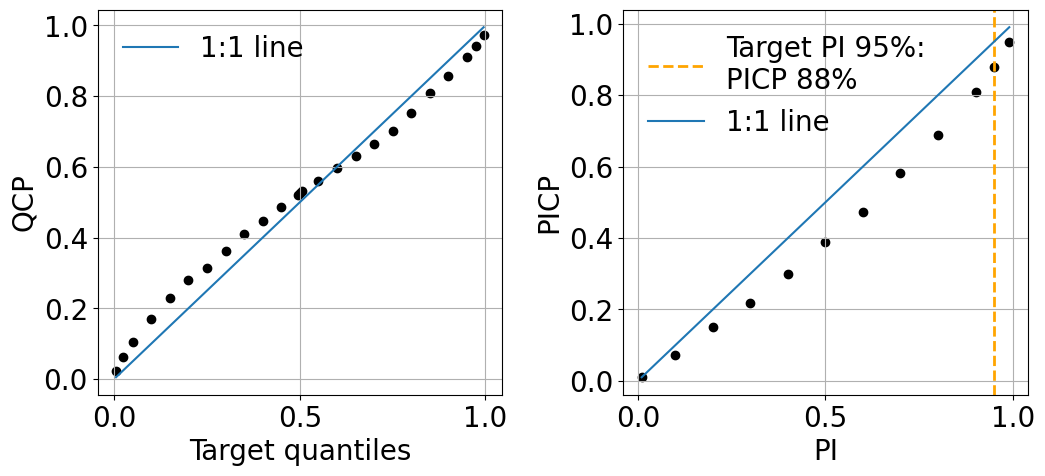

In [58]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Plot 1: Target quantiles vs. realized quantiles
axs[0].plot(quantiles, quantiles, label='1:1 line')
axs[0].scatter(quantiles, qcp, color='black')
axs[0].set_xlabel('Target quantiles', fontsize=20)
axs[0].set_ylabel('QCP', fontsize=20)
axs[0].grid(True)
axs[0].legend(fontsize=20, frameon=False)  # Make legend background transparent
axs[0].tick_params(axis='both', which='major', labelsize=20)

# Plot 2: PI vs. PICP
# ymin, ymax = axs[1].get_ylim()
# axs[1].plot([0.95, 0.95], [0,1], 
#             color='orange', linestyle='--', linewidth=2, label='Target PI 95%:\nPICP 93%')
axs[1].axvline(x=0.95, color='orange', linestyle='--', linewidth=2, label=f'Target PI 95%:\nPICP {picp[1]*100:.0f}%')  # Use axvline to draw a vertical line across the entire plot
axs[1].plot(pi, pi, label='1:1 line')
axs[1].scatter(pi, picp, color='black')
axs[1].set_xlabel('PI', fontsize=20)
axs[1].set_ylabel('PICP', fontsize=20)
# axs[1].text(0.26, 0.16, f'PI 95% - PICP 93%', #\n{picp[1]:.2f}
#             ha='left', va='top', transform=axs[1].transAxes, fontsize=20)  # Adjusted text position
axs[1].grid(True)
axs[1].legend(fontsize=20, frameon=False)  # Make legend background transparent
axs[1].tick_params(axis='both', which='major', labelsize=20)

# Adjust layout to prevent overlapping and add space between the panels
plt.subplots_adjust(wspace=0.3)  # Increase the space between the two plots
# plt.savefig(f'{folder_path}/figure/figure_evaluation_uncertainty.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

## soc change evaluate

In [59]:
tcol = ['lat', 'lon', 'time', 'soc', 'soc_test','soc_test_std', 'lc_survey'] # time series cols
scol = ['id', 'ref', 'nuts0', 'hzn_dep']
ttest['soc_test'] = np.expm1(ttest['soc_log1p_test'])
data_list = []
ttprint('start organizing')
for iid in ttest['id'].unique():
    temp = ttest.loc[ttest['id'] == iid].sort_values(by=['time'])  

    static_vals = temp.iloc[0][scol].tolist()  # Extract static values once

    if len(temp) == 2:
        ts_vals = [temp[itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

    elif len(temp) > 2:
        # Case with 3 points: form 3 pairs
        ts_vals = [temp.iloc[[0, 1]][itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

        ts_vals = [temp.iloc[[1, 2]][itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

        ts_vals = [temp.iloc[[0, 2]][itcol].tolist() for itcol in tcol]
        data_list.append(static_vals + ts_vals)

 # static cols
pair = pd.DataFrame(data_list, columns=scol + [i + '_pair' for i in tcol])
ttprint('finish organizing')

[15:32:02] start organizing


/tmp/ipykernel_398560/3648580324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ttest['soc_test'] = np.expm1(ttest['soc_log1p_test'])


[15:32:03] finish organizing


In [60]:
pair['year_change'] = pair['time_pair'].str[1] - pair['time_pair'].str[0]
pair['soc_change'] = pair['soc_pair'].str[1] - pair['soc_pair'].str[0]
pair['soc_test_change'] = pair['soc_test_pair'].str[1] - pair['soc_test_pair'].str[0]
pair['soc_test_noise'] = np.sqrt(pair['soc_test_std_pair'].str[1]**2 + pair['soc_test_std_pair'].str[0]**2)
pair['snr'] = pair['soc_change'].abs()/pair['soc_test_noise']
pair['soc_mean'] = (pair['soc_pair'].str[1] + pair['soc_pair'].str[0])/2

/tmp/ipykernel_398560/2258906702.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar


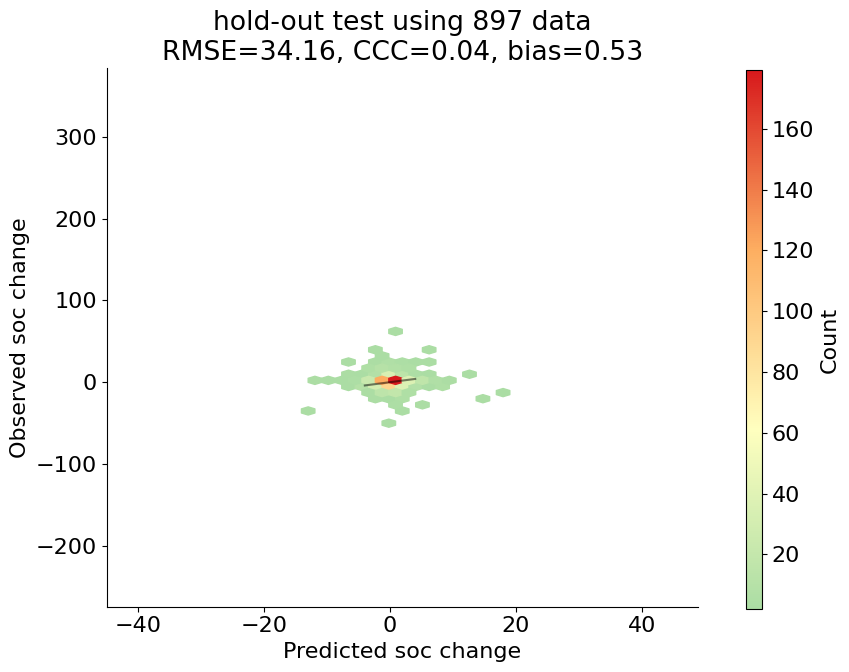

In [61]:
y_test = pair['soc_change']
y_pred = pair['soc_test_change'] 
rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_pred, y_test, 'normal')

# show_range = [
#     math.floor(np.min([y_pred.min(), y_pred.min()])),
#     math.ceil(np.max([y_pred.max(), y_pred.max()]))]
show_range = [-4,4]
vmax = 0.2* len(y_test)

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(8, 7))

ax.set_title(f'hold-out test using {len(y_test)} data\nRMSE={rmse:.2f}, CCC={ccc:.2f}, bias={bias:.2f}')

# Use the CET-L19 colorblind-friendly colormap
hb = ax.hexbin(y_pred, y_test, gridsize=(40, 40), cmap=cet_l19_cmap,mincnt=2, vmax=vmax)
ax.set_xlabel(f'Predicted soc change')
ax.set_ylabel(f'Observed soc change')
ax.set_aspect('auto', adjustable='box')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(show_range, show_range, "-k", alpha=.5)

# Create a colorbar with proper spacing
cax = fig.add_axes([ax.get_position().x1 + 0.05, ax.get_position().y0, 0.02, ax.get_position().height])
cb = fig.colorbar(hb, cax=cax)
cb.set_label('Count')

plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar
# plt.savefig(f'{output_folder}/plot_accuracy.{test_type}_{mdl}.{prop}.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

<Axes: >

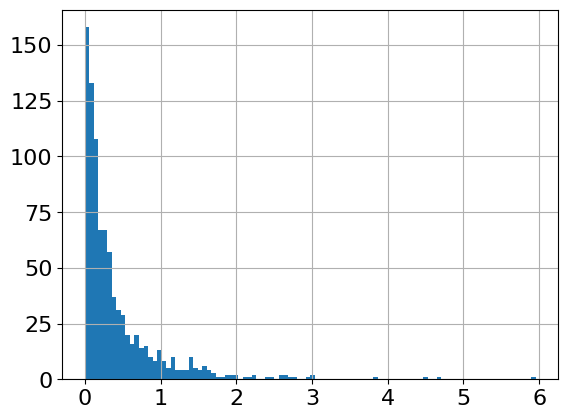

In [62]:
pair['snr'].hist(bins=100)

In [51]:
pair.columns

Index(['id', 'ref', 'nuts0', 'hzn_dep', 'lat_pair', 'lon_pair', 'time_pair',
       'soc_pair', 'soc_test_pair', 'soc_test_std_pair', 'lc_survey_pair',
       'year_change', 'soc_change', 'soc_test_change', 'soc_test_noise',
       'snr'],
      dtype='object')

In [55]:
pair[['soc_mean','year_change', 'soc_change', 'soc_test_change', 'soc_test_noise','snr']].corr(method='spearman')

,soc_mean,year_change,soc_change,soc_test_change,soc_test_noise,snr
soc_mean,1.000000,-0.027142,0.025919,-0.065462,0.331479,-0.138202
year_change,-0.027142,1.000000,-0.043932,-0.022177,0.011259,0.153913
soc_change,0.025919,-0.043932,1.000000,0.050542,0.025139,-0.019227
soc_test_change,-0.065462,-0.022177,0.050542,1.000000,0.065527,-0.048155
soc_test_noise,0.331479,0.011259,0.025139,0.065527,1.000000,-0.469401
snr,-0.138202,0.153913,-0.019227,-0.048155,-0.469401,1.000000
